<a href="https://colab.research.google.com/github/chlolv/NLP_Project/blob/main/Baseline%20-%20Random%20Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Package and definitions


In [1]:
# BERT
# bi LSTM
# Hierarchical cross-entropy ?
# Bonne matrice de confusion

import requests as req
import pandas as pd
import os
import re
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from termcolor import colored
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
try :
  import transformers
except :
  !pip install transformers
  import transformers
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW
from sklearn.utils.class_weight import compute_class_weight
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from itertools import compress
import seaborn as sns
from tqdm import *
import time

# torch.cuda.is_available() returns a boolean to check if the GPU can be used or not
if torch.cuda.is_available():
  # if CUDA is available set 'cuda' as the device
  device = 'cuda'
  # and then print the name of the GPU
  print('DEVICE = ', colored(torch.cuda.get_device_name(0), "green" ) )
else:
  # else, set 'cpu' as device
  device = 'cpu'
  # just print than the CPU is used. Alternatively you can check your CPU with the following command (linux based) in the next cell:
  # ! lscpu
  print('DEVICE = ', colored('CPU', "blue"))

git_url = "https://raw.githubusercontent.com/chlolv/NLP_Project/main/Data/"
H_url = "H_series.csv"
book_url = "book_labels.csv"

# temp fixes due to csv use
H = req.get(git_url + H_url)
H = re.sub('\n\d{0,9}[0-9],',
           '\n', H.text[7:])
words = ["He-", "\\\\", '"', '"', "o-"]
H = re.sub("".join(words), "He-Who", H)
H = re.sub("\*", "" , H)
H = H.split('\n')

book = req.get(git_url + book_url)
book_label_list = re.sub('','0', book.text[6:])
book_label_list = re.sub('010','1', book_label_list)
book_label_list = re.sub('020','2', book_label_list)
book_label_list = re.sub('030','3', book_label_list)
book_label_list = re.sub('040','4', book_label_list)
book_label_list = re.sub('050','5', book_label_list)
book_label_list = re.sub('060','6', book_label_list)
book_label_list = re.sub('070','7', book_label_list)
book_label_list = book_label_list.split('\n')

book_label_list = [int(book) for book in book_label_list]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
DEVICE =  Tesla K80


# Tache de classification des paragraphes

We want our algorithm to predict what characters are in each paragraph. 

In [2]:
# On se rammène à une tâche de classification
character_list = {1: ['Harry', 'Potter'], 2: ['Ron', 'Weasley'], 3: ['Hermione', 'Granger'], 4: ['Snape', 'Severus'], 
                  5:['Albus', 'Dumbledore'], 6: ['Dursley', 'Vernon', 'Dudley', 'Petunia'], 7: ['Draco', 'Malfoy']}
paragraph_character_labels = []
para_id = 0
for paragraph in tqdm_notebook(H) :
  paragraph_character_labels.append('')
  for key in character_list.keys() :
    character = character_list[key]
    if any(name in paragraph for name in character) :
      if paragraph_character_labels[para_id] != '' :
        paragraph_character_labels[para_id] += '_'
      paragraph_character_labels[para_id] += character[0]
  if paragraph_character_labels[para_id] == '' :
    paragraph_character_labels[para_id] += 'None'
  para_id += 1
pd.DataFrame.from_dict(Counter(paragraph_character_labels), orient = 'index').sort_values(by = [0], ascending = [False])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20931 [00:00<?, ?it/s]

,0
Harry,5214
None,3759
Harry_Ron,1758
Harry_Ron_Hermione,1438
Ron,1159
...,...
Ron_Albus_Draco,2
Ron_Hermione_Snape_Draco,2
Ron_Dursley_Draco,1
Harry_Ron_Hermione_Albus_Dursley,1


In [3]:
# On masque les noms propres 
special_data = []
for paragraph in tqdm_notebook(H) :
  tokenized = nltk.word_tokenize(paragraph)
  proper_nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if pos in ['NNP', 'NNPS']] 
  for proper_noun in proper_nouns :
    paragraph = re.sub(proper_noun, 'charoffocus', paragraph)
    paragraph = re.sub('Dumbledore', 'charoffocus', paragraph)
    paragraph = re.sub('dumbledore', 'charoffocus', paragraph)
    paragraph = re.sub('charoffocus charoffocus', 'charoffocus', paragraph)
    paragraph = re.sub('charoffocus charoffocus', 'charoffocus', paragraph)
    paragraph = re.sub('charoffocus charoffocus', 'charoffocus', paragraph)
  special_data.append(paragraph)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/20931 [00:00<?, ?it/s]

In [4]:
textfile = open("special_data.txt", "w")
for element in special_data:
    textfile.write(element + "\n")
textfile.close()

In [5]:
torch.cuda.empty_cache()

In [6]:
seed = 42
stratify_labels = []
labels = paragraph_character_labels

counted_data = pd.DataFrame.from_dict(Counter(paragraph_character_labels), orient = 'index').sort_values(by = [0], ascending = [False])
data_that_matters = counted_data.index[(counted_data[0] > 500) & (counted_data.index != 'None')]

# On rajoute le livre au label et on met en Other les catégories trop petites
# for i in range(0, len(labels)) :
#   if labels[i] in data_that_matters :
#     new_label = labels[i] + '_' + str(book_label_list[i])
#   else :
#     new_label = 'Other' + '_' + str(book_label_list[i])
#   stratify_labels.append(new_label)

# on met en Other les catégories trop petites
for i in range(0, len(labels)) :
  if labels[i] in data_that_matters :
    new_label = labels[i]
  else :
    new_label = 'Other'
  stratify_labels.append(new_label)

liste_unique_labels = np.unique(stratify_labels)
correspondance_label_numeric = list(range(0, len(np.unique(stratify_labels))))
numeric_stratify_labels = pd.DataFrame(stratify_labels).replace(liste_unique_labels, correspondance_label_numeric)
numeric_stratify_labels = list(numeric_stratify_labels[0])


In [171]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
nltk.download('wordnet')

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)
lemmatizer = WordNetLemmatizer()

to_get_veked = [[lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in nltk.word_tokenize(re.sub(r"[^A-Za-z0-9]+", ' ', par.lower()))] for par in tqdm(special_data)]


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


  4%|▍         | 810/20931 [00:20<06:41, 50.12it/s]

KeyboardInterrupt: ignored

In [169]:
import pickle as pickle

with open('to_get_veked.pkl', 'wb') as f:
    pickle.dump(to_get_veked, f)
files.download('to_get_veked.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [172]:
import pickle as pickle

to_get_veked = pd.read_pickle(git_url + 'to_get_veked.pkl')

from gensim.models import Word2Vec

model = Word2Vec(to_get_veked, size=100, window=5, workers=4, min_count=1) 
model.train(to_get_veked, epochs=2, total_examples=len(to_get_veked))


  4%|▍         | 810/20931 [00:31<06:41, 50.12it/s]

(1460749, 2205066)

In [173]:
model.wv.most_similar(positive=['he'])


[('himself', 0.5865914821624756),
 ('awakens', 0.5510671138763428),
 ('midsentence', 0.5263444185256958),
 ('someone', 0.5224764943122864),
 ('charoffocus', 0.513784646987915),
 ('it', 0.5046697854995728),
 ('tock', 0.49786177277565),
 ('broadcast', 0.4974357485771179),
 ('suicidal', 0.4846523702144623),
 ('hard', 0.4845111668109894)]

In [174]:
from sklearn.feature_extraction.text import TfidfVectorizer

def dummy(doc):
    return doc

tfidfvectorizer = TfidfVectorizer(analyzer='word', stop_words='english', tokenizer=dummy, preprocessor=dummy)
tfidf_matrix = tfidfvectorizer.fit_transform(to_get_veked)
tfidf_matrix = pd.DataFrame(tfidf_matrix.toarray(), columns = tfidfvectorizer.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  % sorted(inconsistent)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [217]:
para_coord = []
for i in tqdm(range(0, len(to_get_veked))) :
  para = to_get_veked[i]
  weights = [tfidf_matrix.loc[i, word] if word in tfidf_matrix.columns else 0 for word in para]
  if para == [] :
    para = ['small', 'problem']
    weights = None
  new_coord = np.average(model[para], axis = 0, weights = weights)
  para_coord.append(new_coord)


  0%|          | 0/20931 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  

100%|██████████| 20931/20931 [00:44<00:00, 467.82it/s]


In [249]:
from imblearn.over_sampling import SMOTE


train_text, test_text, train_labels, test_labels = train_test_split(para_coord, numeric_stratify_labels, 
                                                                    random_state = seed, 
                                                                    test_size = 0.1, 
                                                                    stratify = numeric_stratify_labels)
smote = SMOTE(random_state=seed, sampling_strategy = 'all')
train_text, train_labels = smote.fit_resample(train_text, train_labels)

In [250]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth = 100, n_estimators = 200, random_state=0)

clf.fit(train_text, train_labels)
predict = clf.predict(test_text)


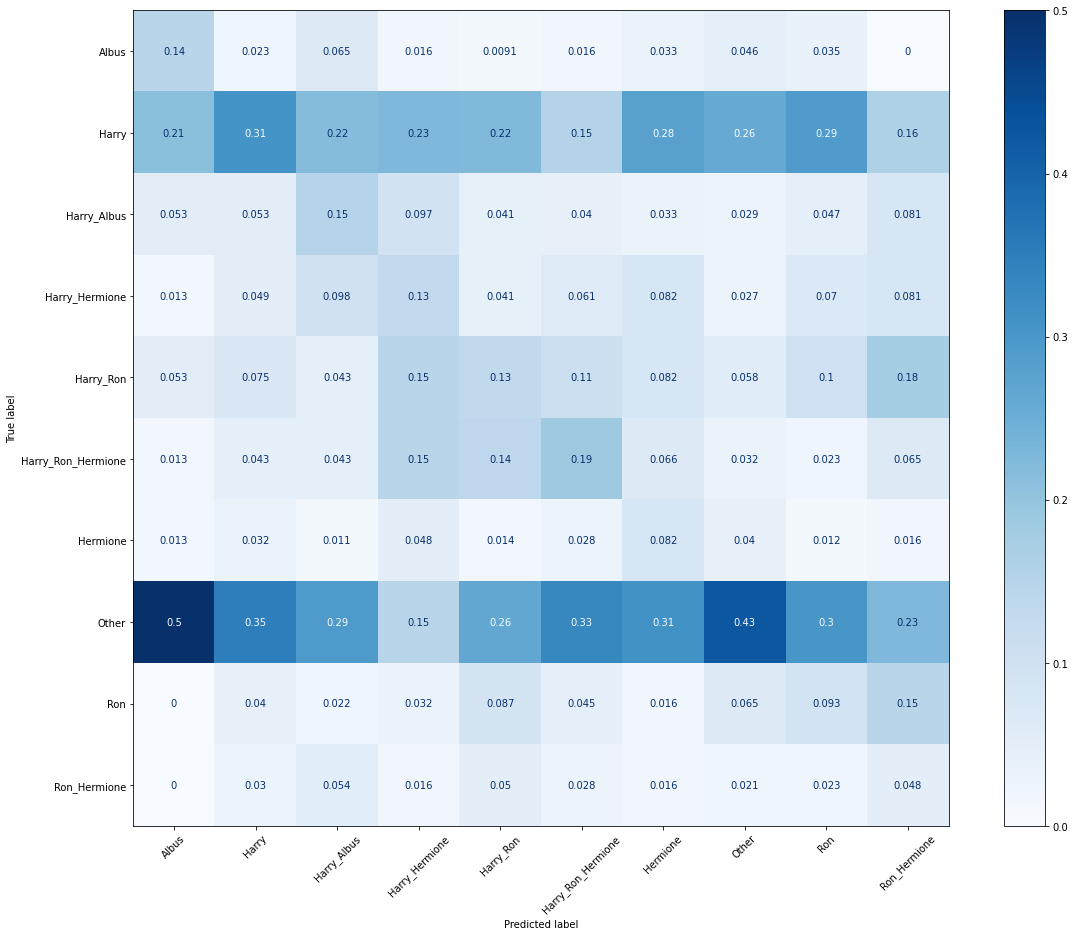

In [251]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# model's performance
plt.rcParams['figure.figsize'] = [20, 15]
cm = confusion_matrix(test_labels, predict, normalize = 'pred') 

cmd = ConfusionMatrixDisplay(cm, display_labels=liste_unique_labels)
cmd.plot(cmap=plt.cm.Blues, xticks_rotation=45)

